In [7]:
import numpy as np
import pandas as pd
import scipy.stats as spstats
from scipy import signal
import pickle
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split

from potentials import potentialRegression
from baselines import construct_ESVM_kernel,split_dataset,set_function,standartize,standartize_train
from optimize import Run_eval_test,optimize_parallel_new
from samplers import MCMC_sampler,Generate_train
from utils import *

## Setting parameters

<p>Datasets:</p>
<ol>
    <li>Pima $(N=768,\ d=8)$</li>
    <li>Eeg $(N=14\,980,\ d=15)$</li>
    <li>Susy $(N=500\,000,\ d=19)$</li>
</ol>

In [8]:
dataset = "pima" # Switch between "pima", "eeg" and "susy" 
intercept = True # Do we include the intercept
degree = 1 #order of CV's: 1 or 2 expected
typ = "logistic" #logistic or probit are expected

sampler = {"sampler":"MALA","burn_type":"full","main_type":"full"} # Sampling method

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
if typ == "logistic":
    #f_type = "posterior_prob_mean"
    f_type = "posterior_mean"
elif typ == "probit":
    f_type = "posterior_prob_mean_probit"
    
step = 0.1

In [9]:
n_traj_train = 1 # Number of independent MCMC trajectories for train
n_traj_test = 100 # Number of independent MCMC trajectories for test

if (dataset == "swiss"):
    batch_size = 1*5
    test_size = 10
    N_b = 1*10**3
    N_train = 1*10**4
    N_test = 1*10**4
elif (dataset == "eeg"):    
    batch_size = 1*15
    test_size = 100
    b_n = 10 #Truncation point
    N_b = 1*10**3 # Burn-in period
    N_train = 1*10**4 # Length of the train trajectory
    N_test = 1*10**4 # Length of the test trajectories
elif (dataset == "pima"):
    batch_size = 1*15
    test_size = 50
    b_n = 20 #Truncation point
    N_b = 1*10**3 #Burn-in period
    N_train = 10**4 #Length of the train trajectory
    N_test = 10**4 #Length of the test trajectory
elif (dataset == "susy"): 
    batch_size =3*19 # Batch size for stochastic gradient
    test_size = 500
    N_b = 1*10**4 # Burn in period
    N_train = 1*10**5 # Number of samples on which we optimize
    N_test = 1*10**6 # Number of samples

## Loading data

In [10]:
if (dataset == "swiss"):
    data = pd.read_csv("../iZAV_code/data/swiss.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "eeg"):   
    data = pd.read_csv("../iZAV_code/data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "pima"):
    data = pd.read_csv("../iZAV_code/data/pima.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "susy"): 
    data = pd.read_csv("data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

## Preprocessing data

In [11]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [12]:
if (f_type == "posterior_mean"):
    X_train = standartize_train(X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=test_size,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

## Creating potential

In [13]:
# Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ, print_info = True)
d = Cur_pot.d 

## Sampling training trajectories

In [14]:
if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_b, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_b, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  4
accepted =  9988


In [15]:
print(traj.shape)

(1, 10000, 9)


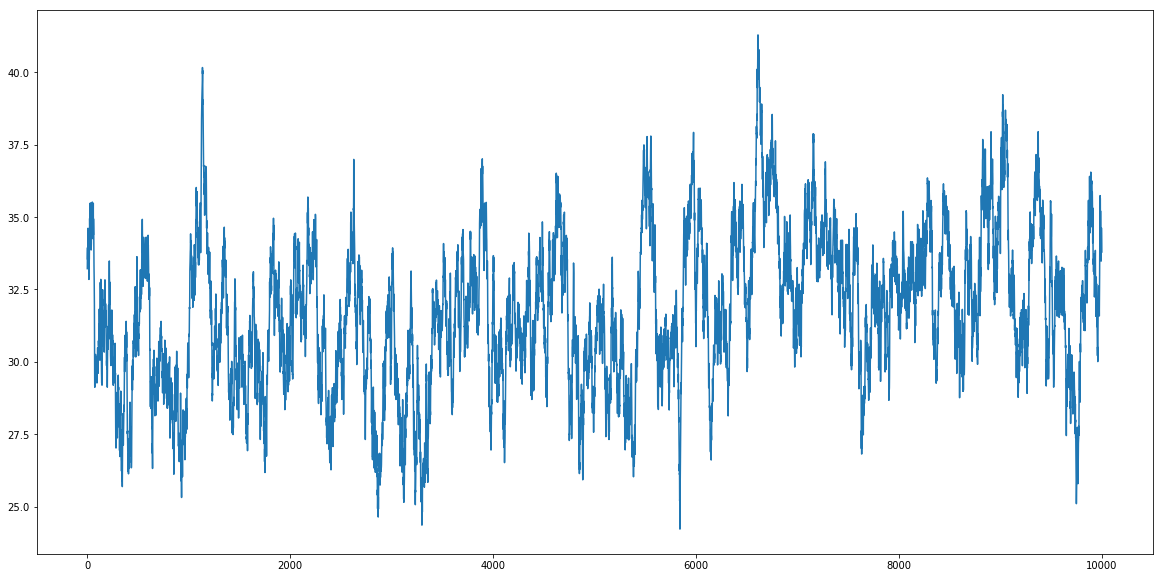

In [16]:
plt.figure(figsize = (20,10))
plt.plot(traj[0,:,2])

## Initialization of function values

If the function you are willing to evaluate is "posterior_prob_point" or "posterior mean" — pass through inds_arr parameter indices of variables, over which you are willing to optimize. For example, in case of "posterior_prob_point",

>inds_arr = np.array([0])

means that you are willing to reduce variance for a point from the test dataset with index $0$.

In [17]:
if (f_type == "posterior_mean"):
    inds_arr = np.array([1]) # Taking the second index (not intercept)
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
    inds_arr = np.array([0])
    
f_vals = set_function(f_type,traj,inds_arr,params)

## Training coefficients for EVM and ESVM

In [18]:
# Construct kernel
W_train_spec = construct_ESVM_kernel(N_train,b_n)
W_test_spec = construct_ESVM_kernel(N_test,b_n)

opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 5, # Number of restarts during optimization,
    "sigma": 1.0, # Deviation of starting points
    "tol": 1e-5, # Tolerance (for the norm of gradient)
    "alpha": 0.0, # Ridge penalty for 2nd order control functionals
    "beta": 10000.0 # smoothing parameter in the softmax
}
methods = ["ESVM","EVM"]

In [19]:
coef_dict = optimize_parallel_new(degree,inds_arr,f_vals,traj,traj_grad,opt_structure_train,methods)

1 degree optimization terminated succesfully
jacobian at termination: 
[ 3.33708240e-08  1.40698355e-07  1.27351551e-07 -1.27618474e-07
 -6.46427428e-09 -2.54554006e-07 -3.51132445e-09  8.78082824e-08
 -8.97462449e-08]
2
1 degree optimization terminated succesfully
jacobian at termination: 
[ 6.25538293e-13  2.50087856e-13 -8.02118438e-13  5.00785940e-13
  5.81828535e-13 -2.83861612e-13  6.97731278e-13 -1.13963601e-12
 -1.16071697e-13]


## Coefficients for control variates

In [20]:
print("Coefficients for ESVM")
print(coef_dict["ESVM"])
print("Coefficients for EVM")
print(coef_dict["EVM"])

Coefficients for ESVM
[[-0.40835498  5.61785897  0.66252611 -0.12981836  0.06450472  0.17179454
   0.43980243  0.03625855  0.1923095 ]]
Coefficients for EVM
[[-0.41016145  5.61614092  0.65864274 -0.13548792  0.06721903  0.16380016
   0.43053198  0.04107263  0.19092645]]


## Testing EVM and ESVM

In [21]:
test_params = {
    "W":W_test_spec,
    "step":step,
    "burn_in":N_b,
    "n_test":N_test,
    "dim":d
}
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,degree,sampler,methods,inds_arr,Cur_pot,test_params,coef_dict,params,f_type) for i in range (n_traj_test)])
trav.close()

In [22]:
methods_enh = ['Vanilla'] + methods
print(methods_enh)
ints_result = {key: [] for key in methods_enh}
vars_result = {key: [] for key in methods_enh}

['Vanilla', 'ESVM', 'EVM']


In [23]:
for i in range(len(res)):
    for j in range(len(methods_enh)):
        ints_result[methods_enh[j]].append(res[i][0][methods_enh[j]][0])
        vars_result[methods_enh[j]].append(res[i][1][methods_enh[j]][0])
for key in methods_enh:
    ints_result[key] = np.asarray(ints_result[key])
    vars_result[key] = np.asarray(vars_result[key])

## Results

In [24]:
print("Estimators")
for i in range(len(methods_enh)):
    print(methods_enh[i])
    print("mean: ",np.mean(ints_result[methods_enh[i]],axis=0))
    print("std: ",np.std(ints_result[methods_enh[i]],axis=0))

Estimators
Vanilla
mean:  [9.71830288]
std:  [0.25956781]
ESVM
mean:  [9.73020332]
std:  [0.00944733]
EVM
mean:  [9.73013461]
std:  [0.00943542]


In [25]:
print("Variances")
for i in range(len(methods_enh)):
    print(methods_enh[i])
    print(np.mean(vars_result[methods_enh[i]],axis=0))

Variances
Vanilla
[260.89273752]
ESVM
[0.41930321]
EVM
[0.41396508]


In [26]:
print("Variance reduction factors")
for i in ["ESVM","EVM"]:
    print(i)
    print(np.mean(vars_result['Vanilla']/vars_result[i]))

Variance reduction factors
ESVM
652.3493674333963
EVM
662.498902592421


## Plotting results

In [27]:
title = ""
labels = ['Vanilla\nRWM', 'RWM\nwith EVM','RWM\nwith ESVM']

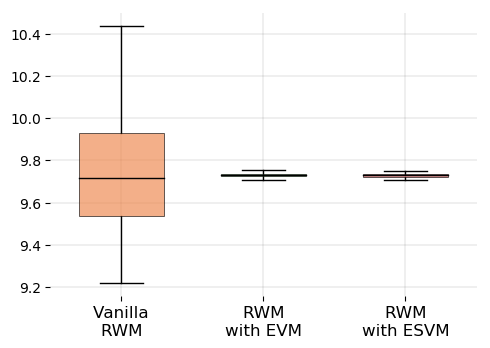

In [28]:
# Box plot
data = [ints_result['Vanilla'][:,0],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)